# Exploration and Random Forests

Goal: Test simple random forest models on the data, dropping any inconvenient features.

In [20]:
import pandas as pd
import numpy as np
import os
import numbers
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read the sample file
co_file = os.path.join("client_start_folder","Co_600K_Jul2019_6M.pkl")
df_co = pd.read_pickle(co_file)

In [3]:
print("   Column                         No of unique values")
for n,c in enumerate(df_co.columns):
    print("{:3d}. {:<35}: {:>6}".format(n,c, len(df_co[c].unique())))
    print("Number of nans: ", df_co[c].isnull().sum())
    print("type of data: ", type(df_co[c][0]))
    print()

   Column                         No of unique values
  0. AccountsAccountCategory            :     16
Number of nans:  0
type of data:  <class 'str'>

  1. AccountsAccountRefDay              :     32
Number of nans:  4
type of data:  <class 'str'>

  2. AccountsAccountRefMonth            :     13
Number of nans:  4
type of data:  <class 'str'>

  3. CompanyCategory                    :      2
Number of nans:  0
type of data:  <class 'str'>

  4. CompanyId                          : 600000
Number of nans:  0
type of data:  <class 'numpy.int64'>

  5. CompanyName                        : 600000
Number of nans:  0
type of data:  <class 'str'>

  6. CompanyNameCountNum                :     16
Number of nans:  0
type of data:  <class 'numpy.int64'>

  7. CompanyNameCountX                  :      5
Number of nans:  0
type of data:  <class 'numpy.int64'>

  8. CompanyNameLen                     :     85
Number of nans:  0
type of data:  <class 'numpy.int64'>

  9. CompanyNameWordLen         

To do list for dealing with features:

Ideas:

    - Drop company Id
    - Drop Company Number (unless it's easy to change)
    
To investigate:


    - CompanyName
    - All the FieldXXX which have more than 500 unique values
    - PreviousName_1CompanyName       
    - RegAddressAddressLine1          
    - RegAddressAddressLine2         
    - RegAddressCareOf                 
    - RegAddressCounty                
    - RegAddressPOBox                 
    - RegAddressPostCode               
    - RegAddressPostTown                                          
    - oa11: need more info on what it represents
    - pcd: need more info on what it represents           
    

Some other features are not numerical but have a small number of unique values and can therefore be encoded using standard techniques.

### Try removing problematic features for now 

In [4]:
zero_info_features = ["CompanyId", "CompanyNumber"]
only_one_value_features = ["Filled", "LimitedPartnershipsNumGenPartners", "LimitedPartnershipsNumLimPartners",\
                          "Status20190701"]

In [5]:
complicated_features = ["RegAddressAddressLine1", "RegAddressAddressLine2", "RegAddressCareOf", "RegAddressCounty", \
                        "RegAddressPOBox", "RegAddressPostCode", "RegAddressPostTown", "pcd", "oa11", "PreviousName_1CompanyName"]

In [87]:
df_curated = df_co.drop(zero_info_features + only_one_value_features + complicated_features, axis=1)

In [88]:
# from catboost feature impotance
# drop 20 least important features
df_curated = df_curated.drop(least_important_features, axis=1)

In [89]:
df_curated = df_curated.drop(least_imp2, axis=1)

### Encoding the categorical data

In [90]:
#Checks if type of a column is numerical
def is_numeric(column):
    i = 0
    while i < len(column) and column[i] is None:
        i += 1
    if i == len(column):
        return "Cannot infer"
    return isinstance(column[i], numbers.Number)

In [91]:
def extract_categorical_feature_names(df):
    return [col for col in df if not is_numeric(df[col].values)]

In [92]:
# modifies df
def convert_col_to(df, col, func):
    return list(map(lambda x: func(x) if x is not None else None, df[col].values))

In [93]:
to_num_cols = ["AccountsAccountRefDay", "AccountsAccountRefMonth", "oac1"]
for col in to_num_cols:
    df_curated[col] = convert_col_to(df_curated, col, float)

# Change None to string 'Nan' so that it is encoded as string
for cat in extract_categorical_feature_names(df_curated):
    df_curated[cat] = df_curated[cat].apply(lambda x: 'Nan' if x is None else x)
    
# This column contained both strings and floats so we convert everything to str
df_curated["ru11ind"] = convert_col_to(df_curated, "ru11ind", str)

In [138]:
#Use a label encoder to encode strings as numerical values
le = preprocessing.LabelEncoder()
cat_features = extract_categorical_feature_names(df_curated)
encoded_data = pd.concat([df_curated.drop(cat_features, axis=1), df_curated[cat_features].apply(le.fit_transform)], axis=1)
encoded_data = encoded_data.reset_index(drop=True)

##### Separate Train from test

In [139]:
## remove 'isfailed' column which is what we want to predict
X, y = encoded_data.drop('isfailed',axis = 1), encoded_data['isfailed'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True,random_state=2020)

# Catboost

In [100]:
encoded_data = df_curated

In [22]:
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric


In [102]:
encoded_data = encoded_data.reset_index(drop=True)

## remove 'isfailed' column which is what we want to predict
X, y = encoded_data.drop('isfailed',axis = 1), encoded_data['isfailed'].values


In [165]:
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, cat_features=cat_features)

In [140]:
# fit catboost model
clf = CatBoostClassifier(depth=10, eval_metric='AUC', l2_leaf_reg=0.3, learning_rate=0.3, loss_function='Logloss')
clf.fit(train_pool)

0:	total: 450ms	remaining: 1m 29s
1:	total: 833ms	remaining: 1m 22s
2:	total: 1.27s	remaining: 1m 23s
3:	total: 1.57s	remaining: 1m 17s
4:	total: 2.01s	remaining: 1m 18s
5:	total: 2.4s	remaining: 1m 17s
6:	total: 2.77s	remaining: 1m 16s
7:	total: 3.2s	remaining: 1m 16s
8:	total: 3.6s	remaining: 1m 16s
9:	total: 3.99s	remaining: 1m 15s
10:	total: 4.37s	remaining: 1m 15s
11:	total: 4.72s	remaining: 1m 14s
12:	total: 5.11s	remaining: 1m 13s
13:	total: 5.48s	remaining: 1m 12s
14:	total: 5.89s	remaining: 1m 12s
15:	total: 6.26s	remaining: 1m 12s
16:	total: 6.62s	remaining: 1m 11s
17:	total: 7s	remaining: 1m 10s
18:	total: 7.38s	remaining: 1m 10s
19:	total: 7.78s	remaining: 1m 10s
20:	total: 8.16s	remaining: 1m 9s
21:	total: 8.55s	remaining: 1m 9s
22:	total: 8.98s	remaining: 1m 9s
23:	total: 9.38s	remaining: 1m 8s
24:	total: 9.76s	remaining: 1m 8s
25:	total: 10.1s	remaining: 1m 7s
26:	total: 10.5s	remaining: 1m 7s
27:	total: 10.9s	remaining: 1m 6s
28:	total: 11.3s	remaining: 1m 6s
29:	total:

### XGBoost 

In [131]:
import xgboost as xgb

In [154]:
xg = xgb.XGBClassifier(learning_rate=0.3, max_depth=10, subsample=0.5, objective='binary:logistic', verbosity=3)

In [155]:
xg.fit(X_train, y_train)

C:\Users\oscar\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:13:50] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/gbm/gbtree.cc:154: Using tree method: 2
[18:13:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=10
[18:13:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:13:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=10
[18:13:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 0 pruned nodes, max_depth=10
[18:13:52] INFO: C:/Users/Administrator/workspace/

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=3)

In [ ]:
cv_results = xgb.cv()

### Optimisation

##### Grid Search

In [23]:
from sklearn.model_selection import GridSearchCV

In [98]:
grid = {
    'learning_rate' : [0.2, 0.3],
    'depth' : [10, 12],
    'loss_function' : ['Logloss'],
    'l2_leaf_reg' : [0.1, 0.2],
    'leaf_estimation_iterations' : [5, 10, 15],
    'eval_metric' : ['AUC']
    'bagging_temperature' : [0, 1]
}

In [99]:
clf = CatBoostClassifier(verbose=0)
clf_grid = GridSearchCV(estimator = clf, param_grid=grid, verbose=3, cv=5, scoring='roc_auc')

In [100]:
clf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] depth=6, eval_metric=AUC, l2_leaf_reg=0.1, leaf_estimation_iterations=10, learning_rate=0.3, loss_function=Logloss 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  depth=6, eval_metric=AUC, l2_leaf_reg=0.1, leaf_estimation_iterations=10, learning_rate=0.3, loss_function=Logloss, score=0.840, total=  48.3s
[CV] depth=6, eval_metric=AUC, l2_leaf_reg=0.1, leaf_estimation_iterations=10, learning_rate=0.3, loss_function=Logloss 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.2s remaining:    0.0s


[CV]  depth=6, eval_metric=AUC, l2_leaf_reg=0.1, leaf_estimation_iterations=10, learning_rate=0.3, loss_function=Logloss, score=0.877, total=  52.1s
[CV] depth=6, eval_metric=AUC, l2_leaf_reg=0.1, leaf_estimation_iterations=10, learning_rate=0.3, loss_function=Logloss 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


[CV]  depth=6, eval_metric=AUC, l2_leaf_reg=0.1, leaf_estimation_iterations=10, learning_rate=0.3, loss_function=Logloss, score=0.862, total=  55.6s
[CV] depth=6, eval_metric=AUC, l2_leaf_reg=0.1, leaf_estimation_iterations=10, learning_rate=0.3, loss_function=Logloss 
[CV]  depth=6, eval_metric=AUC, l2_leaf_reg=0.1, leaf_estimation_iterations=10, learning_rate=0.3, loss_function=Logloss, score=0.861, total=  55.1s
[CV] depth=6, eval_metric=AUC, l2_leaf_reg=0.1, leaf_estimation_iterations=10, learning_rate=0.3, loss_function=Logloss 
[CV]  depth=6, eval_metric=AUC, l2_leaf_reg=0.1, leaf_estimation_iterations=10, learning_rate=0.3, loss_function=Logloss, score=0.854, total=  55.1s
[CV] depth=6, eval_metric=AUC, l2_leaf_reg=0.1, leaf_estimation_iterations=10, learning_rate=0.4, loss_function=Logloss 
[CV]  depth=6, eval_metric=AUC, l2_leaf_reg=0.1, leaf_estimation_iterations=10, learning_rate=0.4, loss_function=Logloss, score=0.842, total=  54.3s
[CV] depth=6, eval_metric=AUC, l2_leaf_re

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 52.6min finished


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001051E7D74F0>,
             param_grid={'depth': [6, 8, 10], 'eval_metric': ['AUC'],
                         'l2_leaf_reg': [0.1],
                         'leaf_estimation_iterations': [10],
                         'learning_rate': [0.3, 0.4],
                         'loss_function': ['Logloss']},
             scoring='roc_auc', verbose=3)

In [104]:
best_param = clf_grid.cv_results_
best_param

{'mean_fit_time': array([ 53.19676719,  55.15043797,  67.0699039 ,  64.5438735 ,
        196.22266431, 194.02494493]),
 'std_fit_time': array([2.77698867, 0.61645874, 0.76037526, 0.84863663, 1.53697329,
        0.4494468 ]),
 'mean_score_time': array([0.05279021, 0.05169234, 0.05164127, 0.0523025 , 0.20104256,
        0.20583463]),
 'std_score_time': array([0.0065499 , 0.00258716, 0.00063068, 0.00225481, 0.01259922,
        0.01546377]),
 'param_depth': masked_array(data=[6, 6, 8, 8, 10, 10],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_eval_metric': masked_array(data=['AUC', 'AUC', 'AUC', 'AUC', 'AUC', 'AUC'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_l2_leaf_reg': masked_array(data=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 

In [130]:
clf = CatBoostClassifier(depth=10, eval_metric='AUC', l2_leaf_reg=0.3, learning_rate=0.3, loss_function='Logloss')
clf.fit(train_pool)

0:	total: 570ms	remaining: 9m 29s
1:	total: 1.16s	remaining: 9m 38s
2:	total: 1.75s	remaining: 9m 40s
3:	total: 2.3s	remaining: 9m 32s
4:	total: 2.85s	remaining: 9m 26s
5:	total: 3.42s	remaining: 9m 27s
6:	total: 3.99s	remaining: 9m 26s
7:	total: 4.55s	remaining: 9m 24s
8:	total: 5.15s	remaining: 9m 27s
9:	total: 5.71s	remaining: 9m 24s
10:	total: 6.28s	remaining: 9m 24s
11:	total: 6.88s	remaining: 9m 26s
12:	total: 7.5s	remaining: 9m 29s
13:	total: 8.07s	remaining: 9m 28s
14:	total: 8.66s	remaining: 9m 28s
15:	total: 9.26s	remaining: 9m 29s
16:	total: 9.86s	remaining: 9m 30s
17:	total: 10.4s	remaining: 9m 28s
18:	total: 11s	remaining: 9m 28s
19:	total: 11.6s	remaining: 9m 27s
20:	total: 12.1s	remaining: 9m 26s
21:	total: 12.8s	remaining: 9m 29s
22:	total: 13.4s	remaining: 9m 29s
23:	total: 14s	remaining: 9m 29s
24:	total: 14.6s	remaining: 9m 28s
25:	total: 15.2s	remaining: 9m 29s
26:	total: 15.8s	remaining: 9m 29s
27:	total: 16.4s	remaining: 9m 29s
28:	total: 17s	remaining: 9m 28s
29:

#### Evaluating the model

Most companies don't fail so accuracy is not a reliable metric. Hence we always use teh AUC score as a metric.

In [117]:
from sklearn.model_selection import cross_validate

Cross Validation

In [120]:
clf = CatBoostClassifier(depth=10, eval_metric='AUC', l2_leaf_reg=0.2, learning_rate=0.3, loss_function='Logloss')
cv_results = cross_validate(clf, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1, return_estimator=True)

In [126]:
cv_results

{'fit_time': array([928.33647418, 934.05844831, 935.12659049, 936.58369565,
        932.17185783]),
 'score_time': array([1.86216235, 0.67818546, 0.49068952, 0.25930595, 1.13559747]),
 'estimator': (<catboost.core.CatBoostClassifier at 0x105abf9d670>,
  <catboost.core.CatBoostClassifier at 0x10521b0e070>),
 'test_score': array([0.88266192, 0.8920612 , 0.88043329, 0.89096808, 0.85850512])}

In [127]:
from sklearn.metrics import roc_auc_score

In [157]:
def evaluate_model(clf):
    print(f"Accuracy - Train: {accuracy_score(y_train, clf.predict(X_train))}")
    print(f"Accuracy - Test: {accuracy_score(y_test, clf.predict(X_test))}")
    
    test_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    train_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
    print(f"Train AUC: {train_auc}")
    print(f"Test AUC: {test_auc}")

In [158]:
evaluate_model(xg)

Accuracy - Train: 0.9999291666666666
Accuracy - Test: 0.9981666666666666
Train AUC: 0.9999994215378114
Test AUC: 0.913692807223643


#### Save model and features it uses in the fitted_models folder

In [159]:
clf.save_model(os.path.join("fitted_models","cb_001"))

In [152]:
with open(os.path.join("fitted_models",'features001.txt'), 'w') as filehandle:    
    filehandle.write('%s\n' % X_train.columns)

#### Features importances

##### Catboost version

C:\Users\oscar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

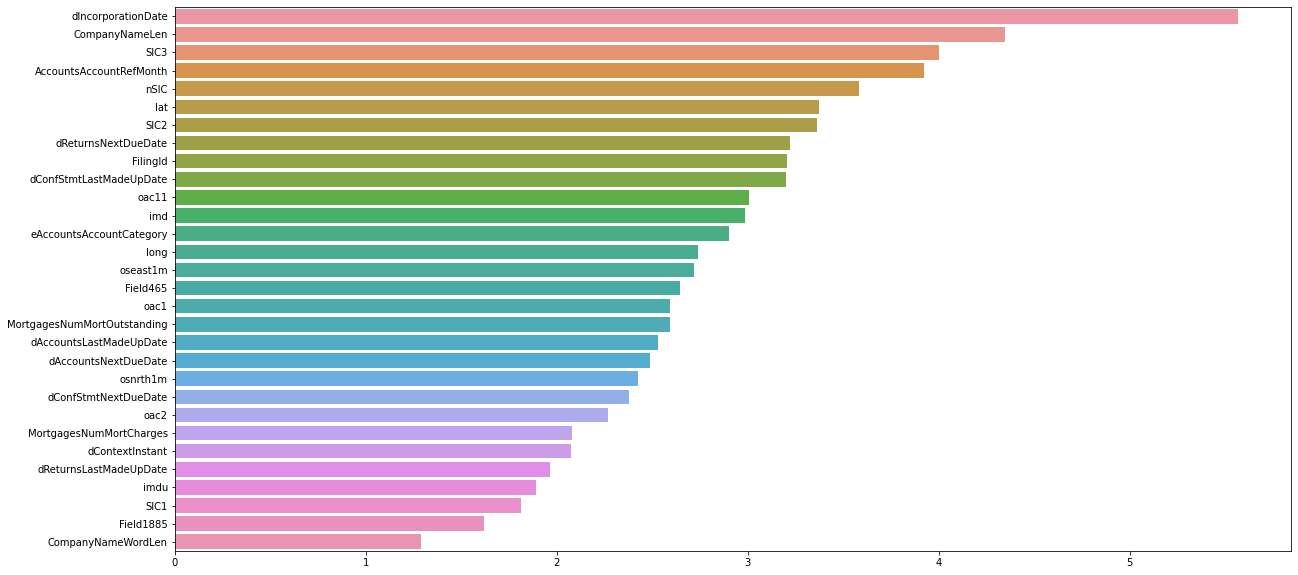

In [146]:
fig, ax = plt.subplots(figsize=(20,10))
sorted_feature_importance = list(sorted(zip(clf.get_feature_importance(), X.columns), key=lambda k: k[0], reverse=True))
sorted_feature_importances, sorted_features = map(list,zip(*sorted_feature_importance))
top_n = 30
sns.barplot(sorted_feature_importances[:top_n], sorted_features[:top_n])

Trying to remove the least important features to speed up testing. They can be added back later on.

In [12]:
least_important_features = ['hasF2619',
 'hasF2705',
 'hasF2815',
 'hasF282',
 'hasF306',
 'hasF448',
 'hasF465',
 'hasF474',
 'hasF487',
 'hasF489',
 'hasF541',
 'hasF69',
 'hasF70',
 'namechanged',
 'namechanged2',
 'CompanyName',
 'CompanyStatus',
 'Field2816',
 'Field2823',
 'Field972']

In [85]:
least_imp2 = 
['Field448', 'Field69', 'Field2497', 'hasGNotice', 'hasF2497', 'CompanyCategory', 'Field2506', 'Field1977', 'Field1522', 'MortgagesNumMortPartSatisfied', 'Field2304', 'Field477', 'country', 'hasF1522', 'Field2483', 'Field2815', 'Field2447', 'hasF1014', 'hasF1129', 'hasF17', 'hasF1865', 'hasF1871', 'hasF1977', 'hasF2298', 'hasF2304', 'hasF2447', 'hasF2483', 'hasF2502', 'hasF2506', 'hasF2616']


['Field448', 'Field69', 'Field2497', 'hasGNotice', 'hasF2497', 'CompanyCategory', 'Field2506', 'Field1977', 'Field1522', 'MortgagesNumMortPartSatisfied', 'Field2304', 'Field477', 'country', 'hasF1522', 'Field2483', 'Field2815', 'Field2447', 'hasF1014', 'hasF1129', 'hasF17', 'hasF1865', 'hasF1871', 'hasF1977', 'hasF2298', 'hasF2304', 'hasF2447', 'hasF2483', 'hasF2502', 'hasF2506', 'hasF2616']


##### XGBoost

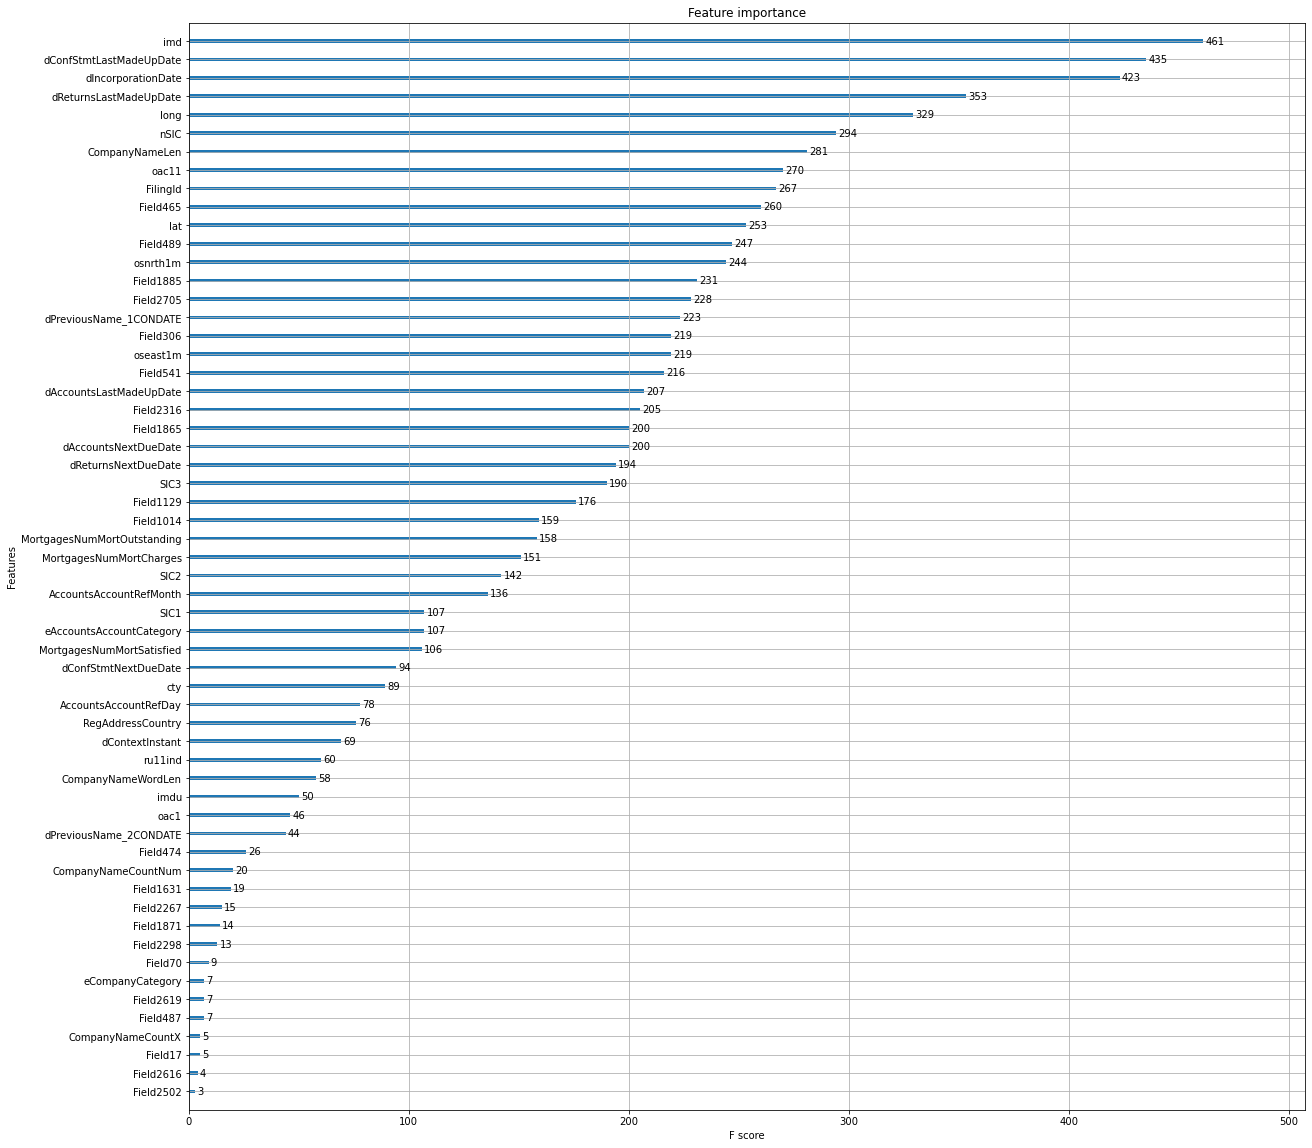

In [162]:
xgb.plot_importance(xg)
plt.rcParams['figure.figsize'] = [40, 40]
plt.show()

In [164]:
type(CatBoostClassifier(depth=10, eval_metric='AUC', l2_leaf_reg=0.2, learning_rate=0.3, loss_function='Logloss'))

catboost.core.CatBoostClassifier